## Solving the Linear Convection Diffusion equation using PINN

PDE $ u_t + c*u_x - v*u_{xx} = 0 $ with c = v = 1<br>
Valid in Domain: $ x \in [-1,1] $ and $ t \in (0,1] $<br>
Initial Condition: $ u(0,x) = - \sin(\pi x) $<br>
Boundary Condition: $ u(t,-1) = u(t,1) = 0 $<br>

In [ ]:
import tensorflow as tf
import math as m

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE) # sets the default float type as 32-bit float
v = tf.constant(1., dtype=DTYPE)
pi = tf.constant(m.pi, dtype=DTYPE)
c = v

def u_init(x): # calculates u value at initial data points
  return -tf.sin(pi * x)

def u_bound(t, x): # calculates u value at boundary data points
  n = x.shape[0]
  return tf.zeros((n,1), dtype=DTYPE)

def f_val(u, u_t, u_x, u_xx): # calculates f value given u and its derivatives
  return u_t + c*u_x - v*u_xx

def u_anal(t,x): # calculates u value from analytical solution
  return -tf.multiply(tf.exp(-pi*pi*t),tf.sin(pi * x))

In [ ]:
Ni, Nb, Nc = 50, 50, 10000 # no of initial, boundary and collocation points

tmin, tmax = tf.constant(0.), tf.constant(1.) # lower and upper limit on time
xmin, xmax = -tf.constant(1.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

ti = tf.ones((Ni,1))*tmin # tmin repeated Ni times
xi = tf.random.uniform((Ni,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
init = tf.concat([ti, xi], axis=1) # Initial Data Points
ui = u_init(xi) # Evaluate Initial Condition

tb = tf.random.uniform((Nb,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
bin = tf.keras.backend.random_bernoulli((Nb,1), 0.5, dtype=DTYPE) # randomly generate 0 or 1 Nb times
xb = xmin + (xmax - xmin) * bin # convert 0s and 1s to xmin and xmax
bound = tf.concat([tb, xb], axis=1) # Boundary Data Points
ub = u_bound(tb, xb) # Evaluate Boundary Condition

tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
coll = tf.concat([tc, xc], axis=1) # Collocation Data Points

In [ ]:
def u_model(n_hidden = 8, n_neurons = 20):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  scaling_layer = tf.keras.layers.Lambda(lambda x: 2.0*(x - tf.stack([tmin, xmin]))/(tf.stack([tmax, xmax]) - tf.stack([tmin, xmin])) - 1.0)
  model.add(scaling_layer)
  for i in range(n_hidden): # n_hidden layers each with n_neurons and tanh activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('tanh'), kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for u
  return model

In [ ]:
def get_f(model, cps): # calculate f given model and collocation data points
  with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
    t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
    tape.watch(t)
    tape.watch(x)
    u = model(tf.concat([t, x], axis=1)) # u as a function of t and x
    u_x = tape.gradient(u, x) # defined within context to compute 2nd derivative
  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)
  del tape
  return f_val(u, u_t, u_x, u_xx)

In [ ]:
def loss_fxn(model, init, ui, bound, ub, coll): # compute Loss given model and data
  pui = model(init) # Model prediction on initial data
  Li = tf.reduce_mean(tf.square(ui - pui)) # MSE for initial data
  pub = model(bound) # Model prediction on boundary data
  Lb = tf.reduce_mean(tf.square(ub - pub)) # MSE for boundary data
  f = get_f(model, coll) # calculate f given model and collocation data
  Lc = tf.reduce_mean(tf.square(f)) # MSE for collocation data (true value of f is always 0)
  loss = Li + Lb + Lc
  return loss

In [ ]:
def L_and_grad_Lw(model, init, ui, bound, ub, coll): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(model.trainable_variables) # keep track of operations on model training parameters
    loss = loss_fxn(model, init, ui, bound, ub, coll) # loss as a function of model (& hence weights)
  g = tape.gradient(loss, model.trainable_variables)
  del tape
  return loss, g

In [ ]:
model = u_model() # initialise the NN model
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1500,3500],[1e-2,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.Adam(learning_rate=lr) # Adam optimizer

In [ ]:
@tf.function
def train_step():
  # compute loss and its gradient wrt model parameters
  loss, gradw = L_and_grad_Lw(model, init, ui, bound, ub, coll)
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gradw, model.trainable_variables))
  return loss

List of Hyperparameters:<br>
1. No of Hidden Layers
2. No of Neurons in each hidden layer
3. Percentage Dropout
4. Activation Function
5. Weight Initialiser
6. Weight Regulariser
7. Optimiser
8. Learning Rate

Final Loss = 0.00014179703
Computation Time = 456.35507822036743 seconds


Text(0, 0.5, 'Loss')

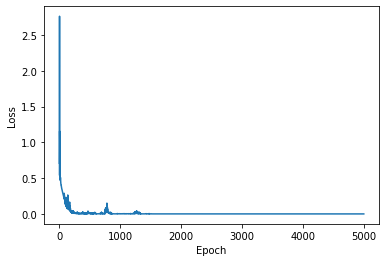

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from time import time
N = 5000 # no of epochs or training iterations
losses = []
t0 = time()
for i in range(1,N+1):
  loss = train_step()
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} seconds'.format(time()-t0))
epochs = [i for i in range(1,N+1)]
import matplotlib.pyplot as plt
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
N = 500
import numpy as np
tspace = np.linspace(tmin, tmax, N+1)
xspace = np.linspace(xmin, xmax, N+1)
T, X = np.meshgrid(tspace, xspace)
grid = np.vstack([T.flatten(),X.flatten()]).T
input = tf.cast(grid,DTYPE)
u_pred = model(input)
U = u_pred.numpy().reshape(N+1,N+1)
t,x = tf.cast(T,DTYPE),tf.cast(X,DTYPE)
u_true = u_anal(t,x)
UT = u_true.numpy().reshape(N+1,N+1)

In [ ]:
U

array([[ 0.02275087,  0.02116781,  0.01967784, ...,  0.00100239,
         0.00100228,  0.00100233],
       [ 0.03407724,  0.03221406,  0.03045198, ...,  0.00104996,
         0.00104971,  0.00104961],
       [ 0.04543506,  0.04329168,  0.04125778, ...,  0.00109764,
         0.00109732,  0.00109695],
       ...,
       [-0.01067028, -0.01263096, -0.01450569, ..., -0.0042905 ,
        -0.00431367, -0.00433698],
       [ 0.00317203,  0.00097862, -0.00112556, ..., -0.00447075,
        -0.0044936 , -0.00451638],
       [ 0.01705015,  0.01462363,  0.0122897 , ..., -0.00465202,
        -0.00467421, -0.00469633]], dtype=float32)

Text(0.5, 0.92, 'PINN Solution')

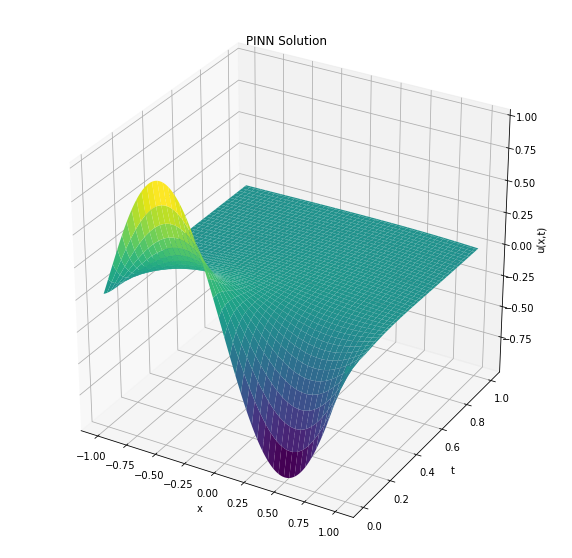

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, T, U, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_title('PINN Solution')

In [ ]:
UT

array([[-8.7422777e-08, -8.5714042e-08, -8.4038703e-08, ...,
        -4.7038645e-12, -4.6119246e-12, -4.5217818e-12],
       [ 1.2565910e-02,  1.2320301e-02,  1.2079492e-02, ...,
         6.7612058e-07,  6.6290539e-07,  6.4994850e-07],
       [ 2.5130162e-02,  2.4638977e-02,  2.4157392e-02, ...,
         1.3521520e-06,  1.3257234e-06,  1.2998112e-06],
       ...,
       [-2.5130162e-02, -2.4638977e-02, -2.4157392e-02, ...,
        -1.3521520e-06, -1.3257234e-06, -1.2998112e-06],
       [-1.2565910e-02, -1.2320301e-02, -1.2079492e-02, ...,
        -6.7612058e-07, -6.6290539e-07, -6.4994850e-07],
       [ 8.7422777e-08,  8.5714042e-08,  8.4038703e-08, ...,
         4.7038645e-12,  4.6119246e-12,  4.5217818e-12]], dtype=float32)

Text(0.5, 0.92, 'Analytical Solution')

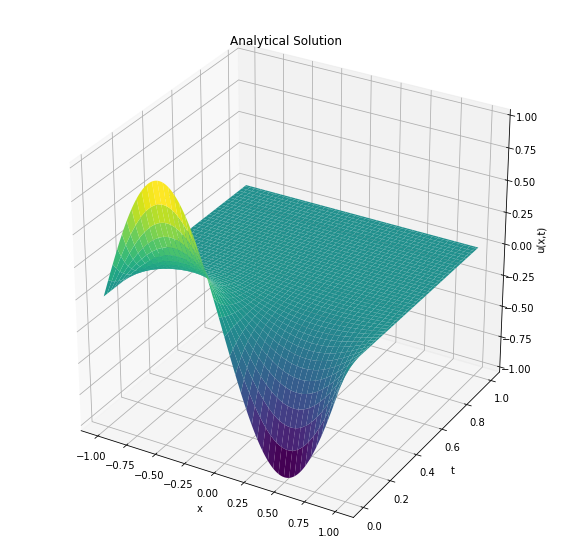

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, T, UT, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_title('Analytical Solution')

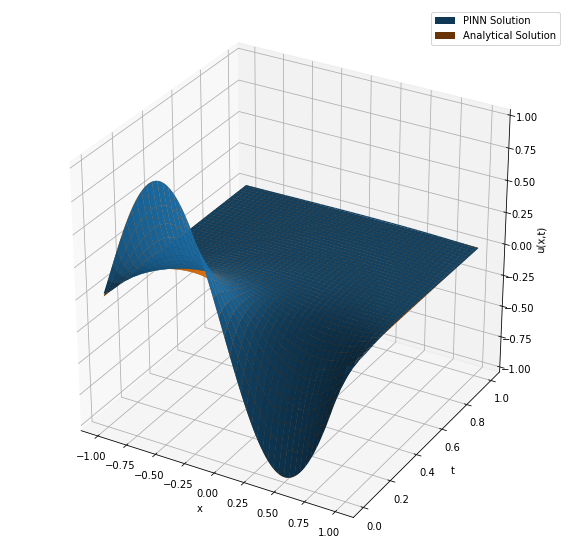

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
c1 = ax.plot_surface(X, T, U, label = 'PINN Solution')
c1._facecolors2d = c1._facecolors3d
c1._edgecolors2d = c1._edgecolors3d
c2 = ax.plot_surface(X, T, UT, label = 'Analytical Solution')
c2._facecolors2d = c2._facecolors3d
c2._edgecolors2d = c2._edgecolors3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.legend()

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(UT.flatten(), U.flatten())

0.0015044486